In [94]:
import sys
import os
import numpy as np
import similaritymeasures
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from textwrap import wrap
import json
import pickle
from zipfile import ZipFile
from math import ceil
from scipy import stats
import re
import markovify as mk

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\Map_Processing")
    sys.path.append(module_path+"\\Note_Timing")
    sys.path.append(module_path+"\\Baseline_Model")

import importlib
importlib.reload(sys.modules['Markov_Chain_model'])

from Markov_Chain_model import get_map_from_song

In [4]:
# Get maps dataframe back from the pickle file
maps_df = pd.read_pickle("../Data_Gather_Filter_Download/downloaded_maps_df.pkl")

In [5]:
with open('../Baseline_Model/markov_model_7_state.json', 'r') as markov_file:
    markov_chain_str = json.load(markov_file)
    markov_chain = mk.Chain.from_json(markov_chain_str)

In [93]:
def count_notes(notes, song_length, bpm):
    counts = [0] * ceil(song_length / 10)
    for note in notes:
        note_time = (note['_time'] / bpm) * 60
        note_bucket = int(note_time / 10)
        if note_time > song_length:
            # print("Note is after song. Time {}, Song length {}, Bucket {}, Num buckets {}".format(note_time, song_length, note_bucket, len(counts)))
            return counts
        counts[note_bucket] += 1
    return counts

In [99]:
def compare_markov_model(maps_df, max_comparisons=100):
    max_r = 0
    average_r = 0
    num_comparisons = 0
    for file_path in maps_df.file_path.unique():
        if num_comparisons > max_comparisons:
            break
        if file_path != "NOT_FOUND":
            with ZipFile("../Data_Gather_Filter_Download/{}".format(file_path)) as folder:
                folder_name = file_path.rsplit('/', 1)[-1]
                folder_name = folder_name.split('.')[0]
                song_length = (maps_df.loc[maps_df['file_path'] == file_path])['length'].values[0]
                bpm = (maps_df.loc[maps_df['file_path'] == file_path])['bpm'].values[0]
                song_name = (maps_df.loc[maps_df['file_path'] == file_path])['song_name'].values[0]
                folder.extractall(path="./Comparisons/{}".format(folder_name))
                filenames = folder.namelist()
                difficulties_dats = [diff for diff in filenames if diff in ["Expert.dat", "ExpertPlus.dat"]]
                human_counts = []
                dat_json = {}
                for difficulties_dat in difficulties_dats:
                    with folder.open(difficulties_dat) as diff_dat:
                        dat_json = json.load(diff_dat)
                        human_counts.append(count_notes(dat_json['_notes'], song_length, bpm))

                song_file = list(filter(lambda x: re.match(r'(^.+\.(egg|ogg|mp4|mp3))', x, flags=re.I), filenames))[0]
                get_map_from_song('./Comparisons/{}/{}'.format(folder_name, song_file), markov_chain, 
                                  model_path='../Baseline_Model/markov_model_7_state.json',  
                                  output_file_path='Generated_{}.dat'.format(folder_name), start_time=1, bpm=bpm
                )
                generated_count = []
                with open('Generated_{}.dat'.format(folder_name), 'r') as gen_map:
                    gen_json = json.load(gen_map)
                    generated_count = count_notes(gen_json['_notes'], song_length, bpm)
                    # print("Gen count:{}".format(generated_count))
                
                # print("Num counts {}".format(len(human_counts)))
                for human_count in human_counts:
                    # print("Human count:{}".format(human_count))

                    pearson_r, _ = stats.pearsonr(human_count, generated_count)
                    pearson_r = abs(pearson_r)
                    print("Pearson_r {}".format(pearson_r))
                    average_r += pearson_r
                    

                    spearman_r = stats.spearmanr(human_count, generated_count)
                    print("Spearman_r {}".format(spearman_r))

                    xvals = [5 + 10*i for i in range(len(human_count))]
                    gen_data = np.zeros((len(human_count), 2))
                    gen_data[:, 0] = xvals
                    gen_data[:, 1] = generated_count

                    human_data = np.zeros((len(human_count), 2))
                    human_data[:, 0] = xvals
                    human_data[:, 1] = human_count

                    curve_len = similaritymeasures.curve_length_measure(human_data, gen_data)
                    fretchet = similaritymeasures.frechet_dist(human_data, gen_data)
                    print("Curve length measure: {}".format(curve_len))
                    print("Fretchet measure: {}".format(fretchet))
                    dtw, _ = similaritymeasures.dtw(human_data, gen_data)
                    print("Dynamic time warping measure: {}".format(dtw))

                    # if pearson_r >= max_r:
                    #     print("New max r: {}, generating plot".format(pearson_r))
                        
                    # max_r = pearson_r
                    plt.figure()
                    title = "Number of notes in 10 second intervals by our Markov chain model and a human mapper on the song {}".format(song_name)
                    plt.subplots_adjust(top=0.85)
                    plt.title('\n'.join(wrap(title, 60)), y = 1.04)
                    
                    plt.plot(xvals, human_count, label="Human-made Map")
                    plt.plot(xvals, generated_count, label="Markov Model Map")
                    plt.xlabel("Song Duration")
                    plt.ylabel("Number of notes")
                    plt.legend(loc='best')
                    plt.text(1, 1, "Pearson_r: {:>4f}\nSpearman_r: {:>4f}\nCurve_len: {:>4f}\nFretchet: {:>4f}\nDTW: {:>4f}".format(
                        pearson_r, spearman_r, curve_len, fretchet, dtw)
                    )
                    plt.show()

                    num_comparisons += 1

    average_r /= num_comparisons
    return average_r    

In [98]:
average_r = compare_markov_model(maps_df, max_comparisons=10)
print(average_r)

Removed 17 onset times for being within 0.1s of the next note
Pearson_r 0.6369151052280486
Spearman_r SpearmanrResult(correlation=-0.4973604826546003, pvalue=0.02566424810208398)
Curve length measure: 2.2352840386040165
Fretchet measure: 38.0
Dynamic time warping measure: 426.0999009328075


NameError: name 'Spearman_r' is not defined

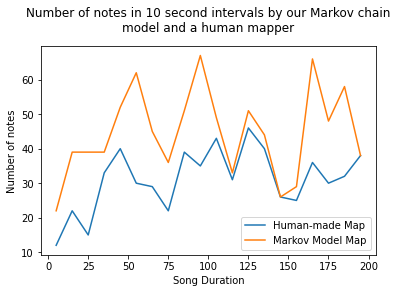

In [23]:
title = "Number of notes in 10 second intervals by our Markov chain model and a human mapper"
plt.subplots_adjust(top=0.85)
plt.title('\n'.join(wrap(title, 60)), y = 1.04)
xvals = [5 + 10*i for i in range(len(counts[0]))]
plt.plot(xvals, counts[0], label="Human-made Map")
plt.plot(xvals, generated_count, label="Markov Model Map")
plt.xlabel("Song Duration")
plt.ylabel("Number of notes")

plt.legend(loc='best')
plt.show()
# plt.savefig('comparison_song_1.png')

In [10]:
r, p = stats.pearsonr(counts[0], generated_count)
print("r:{}\np:{}".format(r, p))

r:0.5656315446326062
p:0.009340972171424341


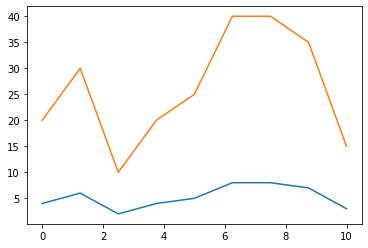

r:1.0
p:0.0


In [13]:
x = np.linspace(0,10,9)        
y1 = np.random.randint(0,10,9)
y2 = [y * 5 for y in y1]
plt.plot(x, y1, label="y1")
plt.plot(x, y2, label="y2")
plt.show()
r, p = stats.pearsonr(y1, y2)
print("r:{}\np:{}".format(r, p))

In [30]:
# Test our model
song_file_name = "(706a)_Redo_(TV_Size)_ReZero_Opening_-_Konomi_Suzuki"
# (7067)_Sorairo_Days_(TV_Size)_Gurren_Lagann_Opening_-_Shoko_Nakagawa

with ZipFile('../Data_Gather_Filter_Download/Zip_Songs_Data/{}.zip'.format(song_file_name)) as folder:
    folder.extract('song.egg')
    get_map_from_song('song.egg', markov_chain, start_time=0, bpm=190)
    os.remove('song.egg')

Removed 12 onset times for being within 0.1s of the next note
Removed 0 onset times for being before the specified start time
Creating output file at Generated_Maps/Expert.dat
c:\Users\Hayde\Documents\UofT Engineering\Fourth Year\Second Semester\APS360\Project\Evaluate_Models


FileNotFoundError: [Errno 2] No such file or directory: 'Generated_Maps/Expert.dat'